# Intro

- Here we parse the provided *training*, *validation* and *test* sets.
- Additionally, the training set is grouped by _cell line_ and _drug pair_.
- The resulting tables are places in the **`az_dream_data`** database.

In [2]:
import os
import os.path as op

import numpy as np
import scipy as sp
import pandas as pd
import sqlalchemy as sa

from IPython.display import display, HTML
import matplotlib.pyplot as plt

import qgrid
qgrid.nbinstall(overwrite=True)
qgrid.set_defaults(remote_js=True, precision=4)

from common import dat

/home/kimlab1/strokach/anaconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context('notebook', font_scale=2.0)

/home/kimlab1/strokach/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Common

In [5]:
# Common
engine = sa.create_engine('mysql://strokach:@192.168.6.19:3306/az_dream_data')
dtype = {
    'CELL_LINE': sa.VARCHAR(255),
    'COMPOUND_A': sa.VARCHAR(255),
    'COMPOUND_B': sa.VARCHAR(255),
    'MAX_CONC_A': sa.dialects.mysql.DOUBLE,
    'MAX_CONC_B': sa.dialects.mysql.DOUBLE,
    'IC50_A': sa.dialects.mysql.DOUBLE,
    'H_A': sa.dialects.mysql.DOUBLE,
    'Einf_A': sa.dialects.mysql.DOUBLE,
    'IC50_B': sa.dialects.mysql.DOUBLE,
    'H_B': sa.dialects.mysql.DOUBLE,
    'Einf_B': sa.dialects.mysql.DOUBLE,
    'SYNERGY_SCORE': sa.dialects.mysql.DOUBLE,
    'QA': sa.INTEGER,
    'COMBINATION_ID': sa.VARCHAR(255),
}

def export_to_db(df, table_name, engine=engine, dtype=dtype):
    df.to_sql(table_name, engine, index=False, if_exists='replace', dtype=dtype)
    engine.execute('create index a on {} (COMBINATION_ID, COMPOUND_A, COMPOUND_B)'.format(table_name))
    engine.execute('create index b on {} (COMPOUND_A, COMPOUND_B, COMBINATION_ID)'.format(table_name))
    engine.execute('create index c on {} (COMBINATION_ID, CELL_LINE)'.format(table_name))
    engine.execute('create index d on {} (CELL_LINE, COMBINATION_ID)'.format(table_name))
    engine.execute('create index e on {} (COMPOUND_A, MAX_CONC_A)'.format(table_name))
    engine.execute('create index f on {} (COMPOUND_B, MAX_CONC_B)'.format(table_name))

# Training

## ch1_train_combination_and_monotherapy

In [6]:
ch1_train_combination_and_monotherapy = pd.read_csv(
    'challenge_data/drug_synergy_data/ch1_train_combination_and_monotherapy.csv/'
    'ch1_train_combination_and_monoTherapy.csv', sep=','
)

In [7]:
ch_1_compounds = (
    set(ch1_train_combination_and_monotherapy['COMPOUND_A']) |
    set(ch1_train_combination_and_monotherapy['COMPOUND_B'])
)

display(ch1_train_combination_and_monotherapy.head())
dat.print2('Number of rows:', len(ch1_train_combination_and_monotherapy))
dat.print2('Number of cell lines:', len(set(ch1_train_combination_and_monotherapy['CELL_LINE'])))
dat.print2('Number of compoounds:', len(ch_1_compounds))

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID
0,BT-20,ADAM17,AKT,1,75,1.000000,0.809002,59.122436,9.639714,0.757977,91.593425,29.540390,1,ADAM17.AKT
1,CAL-120,ADAM17,AKT,1,75,0.183214,2.503678,60.411999,1.000000,0.000000,100.000000,4.401410,-1,ADAM17.AKT
2,CAL-51,ADAM17,AKT,1,75,1.000000,0.726984,11.150843,75.000000,0.375043,76.656479,0.315422,1,ADAM17.AKT
3,DU-4475,ADAM17,AKT,1,75,0.321533,10.000000,58.599487,75.000000,1.995866,6.171007,-41.734090,-1,ADAM17.AKT
4,HCC1143,ADAM17,AKT,1,75,0.398673,10.000000,89.098894,1.000000,0.000000,100.000000,35.532770,-1,ADAM17.AKT


Number of rows:                                             2199
Number of cell lines:                                       85
Number of compoounds:                                       69


There is *some* correlation when we look at `ic50` values for the same cells, but that correlation dissappears when we look at `ic50` values for the same compound but different cells / max_conc values. The other parameters show no correlation... Maybe it's best to use AUC instead?..

In [8]:
assert not ch1_train_combination_and_monotherapy.isnull().any().any()

In [9]:
# Save to database
export_to_db(ch1_train_combination_and_monotherapy, 'training')

### Add weights

In [10]:
def get_weight(QA):
    if QA == 1:
        return 1
    elif QA == -1:
        return 0.01
    elif QA == -2:
        return 0.01
    elif QA == -3:
        return 0.01
    else:
        raise Exception()

In [11]:
combinations_df_1 = ch1_train_combination_and_monotherapy.copy()
combinations_df_1['WEIGHT'] = combinations_df_1['QA'].apply(get_weight)

### Group by drug

In [20]:
training_by_drug = pd.concat([
    combinations_df_1[['COMPOUND_A', 'SYNERGY_SCORE', 'WEIGHT']]
    .rename(columns={
            'COMPOUND_A': 'COMPOUND',
        }),
    combinations_df_1[['COMPOUND_B', 'SYNERGY_SCORE', 'WEIGHT']]
    .rename(columns={
            'COMPOUND_B': 'COMPOUND',
        }),
])

In [23]:
from functions import *
training_gby_drug = get_weighted_stats(
    training_by_drug, 'COMPOUND', 'SYNERGY_SCORE', 'WEIGHT')

In [24]:
display(training_gby_drug.head())
print(training_gby_drug.shape[0])

,COMPOUND,LEN,LEN_UNWEIGHTED,MEAN,MEAN_UNWEIGHTED,STD,STD_UNWEIGHTED,STE,STE_UNWEIGHTED,CONFIDENCE
0,ADAM17,85.18,103,6.077150,3.639117,19.048473,20.762748,2.063913,2.045814,0.878415
1,AKT,209.48,257,12.990700,4.981951,26.395353,41.300744,1.823712,2.576270,0.927703
2,AKT_1,149.20,169,16.016789,12.759452,25.594104,30.527971,2.095345,2.348305,0.872394
3,AKT_SGK,46.02,48,10.049147,9.716044,18.992123,18.772570,2.799627,2.709587,0.756963
4,ALK,37.14,51,16.966631,12.950270,20.245268,27.845114,3.322023,3.899096,0.688810


69


In [25]:
training_gby_drug[training_gby_drug['MEAN'].isnull()]

,COMPOUND,LEN,LEN_UNWEIGHTED,MEAN,MEAN_UNWEIGHTED,STD,STD_UNWEIGHTED,STE,STE_UNWEIGHTED,CONFIDENCE


4.87397482378


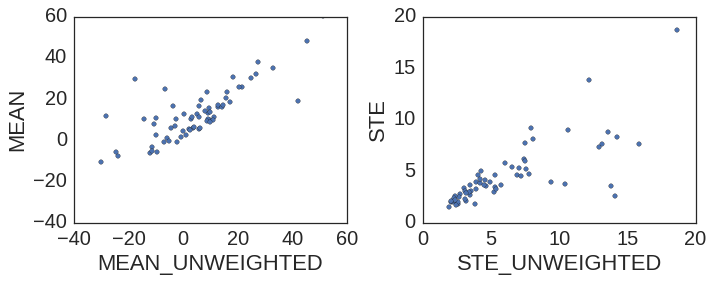

In [27]:
# Compare weighted and unweighted values
fg, ax = plt.subplots(1, 2, figsize=(10, 4))
training_gby_drug.plot(y='MEAN', x='MEAN_UNWEIGHTED', kind='scatter', ax=ax[0])
ax[0].set_xlim(-40, 60)
ax[0].set_ylim(-40, 60)
training_gby_drug.plot(y='STE', x='STE_UNWEIGHTED', kind='scatter', ax=ax[1])
ax[1].set_xlim(0, 20)
ax[1].set_ylim(0, 20)
plt.tight_layout()
print(training_gby_drug['STE'].mean())

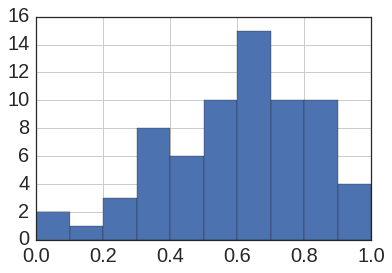

In [28]:
training_gby_drug['CONFIDENCE'].hist()

### Group by drug pair

In [711]:
from functions import *
training_gby_drugpair = get_weighted_stats(
    combinations_df_1, 'COMBINATION_ID', 'SYNERGY_SCORE', 'WEIGHT')

In [712]:
display(training_gby_drugpair.head())
print(training_gby_drugpair.shape[0])

,COMBINATION_ID,LEN,LEN_UNWEIGHTED,MEAN,MEAN_UNWEIGHTED,STD,STD_UNWEIGHTED,STE,STE_UNWEIGHTED,CONFIDENCE
0,ADAM17.AKT,10.04,14,9.770357,5.005206,17.719676,23.066728,5.592280,6.164842,0.589056
1,ADAM17.BCL2_BCL2L1,11.01,12,-3.388489,-4.554570,5.488376,6.539051,1.654056,1.887661,0.988667
2,ADAM17.FGFR,10.03,13,-4.716887,-8.917044,17.181397,20.848170,5.425103,5.782242,0.599013
3,ADAM17.MAP2K_1,11.02,13,-1.440116,-6.053760,15.827779,18.690474,4.767923,5.183805,0.641372
4,ADAM17.MTOR_1,10.04,14,9.601635,9.625085,17.535949,15.960108,5.534296,4.265518,0.592476


169


In [713]:
training_gby_drugpair[training_gby_drugpair['MEAN'].isnull()]

,COMBINATION_ID,LEN,LEN_UNWEIGHTED,MEAN,MEAN_UNWEIGHTED,STD,STD_UNWEIGHTED,STE,STE_UNWEIGHTED,CONFIDENCE


7.27268691437


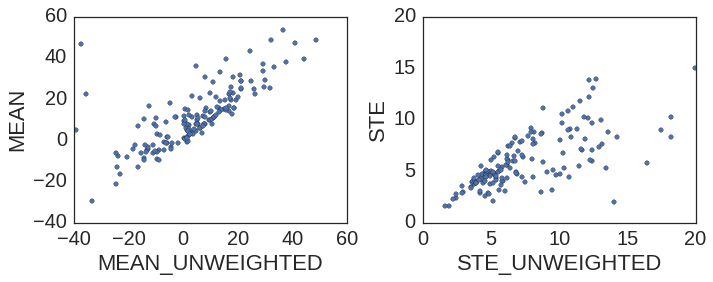

In [714]:
# Compare weighted and unweighted values
fg, ax = plt.subplots(1, 2, figsize=(10, 4))
training_gby_drugpair.plot(y='MEAN', x='MEAN_UNWEIGHTED', kind='scatter', ax=ax[0])
ax[0].set_xlim(-40, 60)
ax[0].set_ylim(-40, 60)
training_gby_drugpair.plot(y='STE', x='STE_UNWEIGHTED', kind='scatter', ax=ax[1])
ax[1].set_xlim(0, 20)
ax[1].set_ylim(0, 20)
plt.tight_layout()
print(training_gby_drugpair['STE'].mean())

The weighted dataset in general has a smaller standard deviation, which is good.

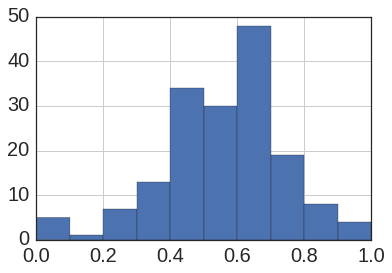

In [715]:
training_gby_drugpair['CONFIDENCE'].hist()

### Group by cell line

In [716]:
from functions import *
training_gby_cell = get_weighted_stats(
    combinations_df_1, 'CELL_LINE', 'SYNERGY_SCORE', 'WEIGHT')

In [717]:
display(training_gby_cell.head())
print(training_gby_cell.shape[0])

,CELL_LINE,LEN,LEN_UNWEIGHTED,MEAN,MEAN_UNWEIGHTED,STD,STD_UNWEIGHTED,STE,STE_UNWEIGHTED,CONFIDENCE
0,22RV1,2.00,2,-8.601674,-8.601674,5.217406,5.217406,3.689263,3.689263,0.762318
1,647-V,23.00,23,13.834063,13.834063,24.923975,24.923975,5.197008,5.197008,0.660662
2,A549,16.04,20,24.877803,21.671942,35.921460,34.170838,8.969161,7.640832,0.498767
3,BFTC-905,25.00,25,21.839952,21.839952,33.543954,33.543954,6.708791,6.708791,0.584912
4,BT-20,51.00,51,22.283808,22.283808,20.415080,20.415080,2.858683,2.858683,0.837988


85


In [718]:
training_gby_cell[training_gby_cell['MEAN'].isnull()]

,CELL_LINE,LEN,LEN_UNWEIGHTED,MEAN,MEAN_UNWEIGHTED,STD,STD_UNWEIGHTED,STE,STE_UNWEIGHTED,CONFIDENCE


7.60809185077


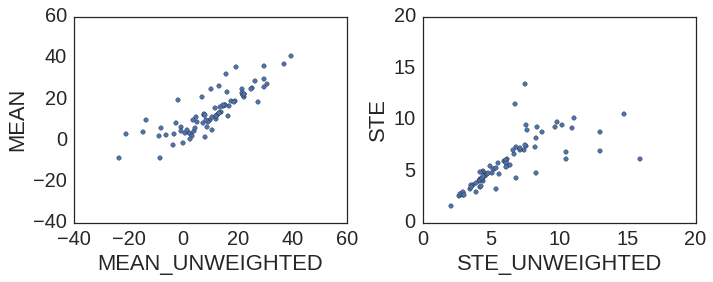

In [719]:
# Compare weighted and unweighted values
fg, ax = plt.subplots(1, 2, figsize=(10, 4))
training_gby_cell.plot(y='MEAN', x='MEAN_UNWEIGHTED', kind='scatter', ax=ax[0])
ax[0].set_xlim(-40, 60)
ax[0].set_ylim(-40, 60)
training_gby_cell.plot(y='STE', x='STE_UNWEIGHTED', kind='scatter', ax=ax[1])
ax[1].set_xlim(0, 20)
ax[1].set_ylim(0, 20)
plt.tight_layout()
print(training_gby_cell['STE'].mean())

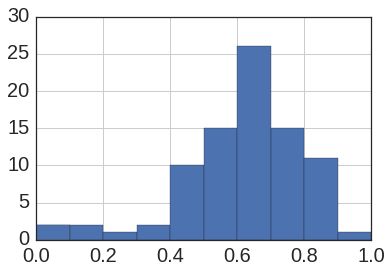

In [720]:
training_gby_cell['CONFIDENCE'].hist()

### Export

In [30]:
# Save to database
def export_gby_to_db(df, table_name, group_by_column):
    engine = sa.create_engine('mysql://strokach:@192.168.6.19:3306/az_dream_data')
    dtype = {
        group_by_column: sa.VARCHAR(255),
        'LEN': sa.dialects.mysql.DOUBLE,
        'LEN_UNWEIGHTED': sa.INTEGER,
        'MEAN': sa.dialects.mysql.DOUBLE,
        'MEAN_UNWEIGHTED': sa.dialects.mysql.DOUBLE,
        'STD': sa.dialects.mysql.DOUBLE,
        'STD_UNWEIGHTED': sa.dialects.mysql.DOUBLE,
        'STE': sa.dialects.mysql.DOUBLE,
        'STE_UNWEIGHTED': sa.dialects.mysql.DOUBLE,
        'CONFIDENCE': sa.dialects.mysql.DOUBLE,
    }
    df.to_sql(table_name, engine, index=False, if_exists='replace', dtype=dtype)
    engine.execute('create index f on {} ({})'.format(table_name, group_by_column))
    
export_gby_to_db(training_gby_drug, 'training_gby_drug', 'COMPOUND')
export_gby_to_db(training_gby_drugpair, 'training_gby_drugpair', 'COMBINATION_ID')
export_gby_to_db(training_gby_cell, 'training_gby_cell', 'CELL_LINE')

# Validation

## ch1_leaderboard_monotherapy

In [722]:
ch1_leaderboard_monotherapy = pd.read_csv(
    'challenge_data/drug_synergy_data/ch1_leaderboard_monotherapy.csv/'
    'ch1_leaderBoard_monoTherapy.csv', sep=','
)

In [723]:
display(ch1_leaderboard_monotherapy.head())
print(ch1_leaderboard_monotherapy.shape[0])

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID
0,BT-549,ADAM17,AKT,1,75,0.184408,1.737511,59.575233,1.0000,0.000000,100.000000,NaN,1,ADAM17.AKT
1,CAL-148,ADAM17,AKT,1,75,0.153391,1.754123,1.100779,1.0000,0.000000,100.000000,NaN,1,ADAM17.AKT
2,HCC38,ADAM17,AKT,1,75,1.000000,10.000000,64.400080,1.0000,0.000000,100.000000,NaN,1,ADAM17.AKT
3,BT-20,ADAM17,BCL2_BCL2L1,1,75,1.000000,1.161732,39.164587,75.0000,0.965792,70.915033,NaN,1,ADAM17.BCL2_BCL2L1
4,HCC1143,ADAM17,BCL2_BCL2L1,1,75,0.115309,10.000000,57.198795,0.0075,0.100000,80.128089,NaN,1,ADAM17.BCL2_BCL2L1


591


In [724]:
#qgrid.show_grid(ch1_leaderboard_monotherapy, grid_options={'forceFitColumns': False})

In [725]:
assert (ch1_leaderboard_monotherapy['QA'] == 1).all()

In [726]:
ch1_leaderboard_monotherapy[ch1_leaderboard_monotherapy['COMBINATION_ID'].isin(
        {'PIK3CB_PIK3CD.PIK3CB_PIK3CD', 'PIK3C_2.PIK3CA_4'}
    )]

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID
496,CAMA-1,PIK3C_2,PIK3CA_4,1,1,1.000000,0.457188,84.258766,0.999878,10.000000,22.047393,NaN,1,PIK3C_2.PIK3CA_4
497,HCC1395,PIK3C_2,PIK3CA_4,1,1,0.999133,10.000000,75.307146,0.938976,1.575386,0.000000,NaN,1,PIK3C_2.PIK3CA_4
498,HCC70,PIK3C_2,PIK3CA_4,1,1,1.000000,0.000000,100.000000,1.000000,0.000000,100.000000,NaN,1,PIK3C_2.PIK3CA_4
499,MDA-MB-453,PIK3C_2,PIK3CA_4,1,1,0.165314,1.035025,0.000000,0.359188,1.984101,0.000000,NaN,1,PIK3C_2.PIK3CA_4


In [727]:
# Save to database
export_to_db(ch1_leaderboard_monotherapy, 'ch1_validation')

## ch1_test_monotherapy

In [728]:
ch1_test_monotherapy = pd.read_csv(
    'challenge_data/drug_synergy_data/ch1_test_monotherapy.csv/'
    'ch1_test_monoTherapy.csv', sep=','
)

In [729]:
display(ch1_test_monotherapy.head())
print(ch1_test_monotherapy.shape[0])

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID
0,CAMA-1,ADAM17,AKT,1,75,0.126186,0.993706,3.688533,1.000000,0.000000,100.000000,NaN,1,ADAM17.AKT
1,HCC1395,ADAM17,AKT,1,75,0.910569,0.552451,0.000000,10.905410,0.239641,82.740876,NaN,1,ADAM17.AKT
2,Hs-578-T,ADAM17,AKT,1,75,1.000000,0.258989,17.701706,0.540880,4.851464,73.495692,NaN,1,ADAM17.AKT
3,MDA-MB-157,ADAM17,AKT,1,75,1.000000,0.215696,5.095356,0.010219,0.227937,52.121460,NaN,1,ADAM17.AKT
4,MDA-MB-468,ADAM17,AKT,1,75,0.509420,0.941494,26.827759,7.328496,10.000000,94.799897,NaN,1,ADAM17.AKT


1089


In [730]:
#qgrid.show_grid(ch1_test_monotherapy, grid_options={'forceFitColumns': False})

In [731]:
assert (ch1_test_monotherapy['QA'] == 1).all()

In [732]:
ch1_test_monotherapy[ch1_test_monotherapy['COMBINATION_ID'].isin(
        {'PIK3CB_PIK3CD.PIK3CB_PIK3CD', 'PIK3C_2.PIK3CA_4'}
    )]

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID
910,CAL-120,PIK3C_2,PIK3CA_4,1,1,1.000000,0.273987,60.496658,0.314484,10.000000,55.499556,NaN,1,PIK3C_2.PIK3CA_4
911,CAL-148,PIK3C_2,PIK3CA_4,1,1,1.000000,1.028243,13.610908,1.000000,2.060549,49.705016,NaN,1,PIK3C_2.PIK3CA_4
912,CAL-51,PIK3C_2,PIK3CA_4,1,1,1.000000,1.060688,34.187296,0.684454,2.182298,0.000000,NaN,1,PIK3C_2.PIK3CA_4
913,DU-4475,PIK3C_2,PIK3CA_4,1,1,0.861321,0.816326,0.000000,0.238304,2.729788,0.186418,NaN,1,PIK3C_2.PIK3CA_4
914,HCC1428,PIK3C_2,PIK3CA_4,1,1,1.000000,0.000000,100.000000,0.308941,10.000000,40.999451,NaN,1,PIK3C_2.PIK3CA_4
915,HCC1806,PIK3C_2,PIK3CA_4,1,1,0.342154,10.000000,50.398904,0.387700,2.770612,7.988054,NaN,1,PIK3C_2.PIK3CA_4
916,MFM-223,PIK3C_2,PIK3CA_4,1,1,0.260349,1.698496,41.735888,0.339836,10.000000,25.198446,NaN,1,PIK3C_2.PIK3CA_4


In [733]:
# Save to database
export_to_db(ch1_test_monotherapy, 'ch1_test')

## ch2_leaderboard_monotherapy

In [734]:
ch2_leaderboard_monotherapy = pd.read_csv(
    'challenge_data/drug_synergy_data/ch2_leaderboard_monotherapy.csv/'
    'ch2_leaderBoard_monoTherapy.csv', sep=','
)

In [735]:
ch2_leaderboard_monotherapy.head()

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID
0,BT-20,ADAM17,AKT_1,1,75,1.000000,0.574284,38.240698,75,0.450168,62.480250,NaN,1,ADAM17.AKT_1
1,BT-549,ADAM17,AKT_1,1,75,0.171407,1.100645,54.327200,1,0.000000,100.000000,NaN,1,ADAM17.AKT_1
2,CAL-120,ADAM17,AKT_1,1,75,1.000000,0.000000,100.000000,1,0.000000,100.000000,NaN,1,ADAM17.AKT_1
3,CAL-148,ADAM17,AKT_1,1,75,0.208764,1.500265,15.526343,1,0.000000,100.000000,NaN,1,ADAM17.AKT_1
4,CAL-51,ADAM17,AKT_1,1,75,1.000000,1.205139,56.710392,75,0.526078,78.676247,NaN,1,ADAM17.AKT_1


In [736]:
#qgrid.show_grid(ch2_leaderboard_monotherapy, grid_options={'forceFitColumns': False})

In [737]:
assert (ch2_leaderboard_monotherapy['QA'] == 1).all()

In [738]:
ch2_leaderboard_monotherapy[ch2_leaderboard_monotherapy['COMBINATION_ID'].isin(
        {'PIK3CB_PIK3CD.PIK3CB_PIK3CD', 'PIK3C_2.PIK3CA_4'}
    )]

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID


In [739]:
# Save to database
export_to_db(ch2_leaderboard_monotherapy, 'ch2_validation')

## ch2_test_monotherapy

In [740]:
ch2_test_monotherapy = pd.read_csv(
    'challenge_data/drug_synergy_data/ch2_test_monotherapy.csv/'
    'ch2_test_monoTherapy.csv', sep=','
)

In [741]:
ch2_test_monotherapy.head()

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID
0,22RV1,AKT,AR,10,1,1.000000,0.000000,100.000000,0.345308,1.326704,64.791166,NaN,1,AKT.AR
1,VCaP,AKT,AR,10,1,2.654045,0.575220,60.632962,0.330855,3.876610,67.256669,NaN,1,AKT.AR
2,VCaP,AKT,BCL2,10,1,1.000000,0.000000,100.000000,0.313434,1.862979,57.750781,NaN,1,AKT.BCL2
3,COLO-205,AKT,BRAF_M,3,3,0.204405,1.757878,6.447588,1.206550,2.540437,0.000000,NaN,1,AKT.BRAF_M
4,NCI-H747,AKT,BRAF_M,3,3,0.000300,0.100000,83.122450,0.170654,0.648855,0.000000,NaN,1,AKT.BRAF_M


In [742]:
#qgrid.show_grid(ch2_test_monotherapy, grid_options={'forceFitColumns': False})

In [743]:
assert (ch2_test_monotherapy['QA'] == 1).all()

In [744]:
ch2_test_monotherapy[ch2_test_monotherapy['COMBINATION_ID'].isin(
        {'PIK3CB_PIK3CD.PIK3CB_PIK3CD', 'PIK3C_2.PIK3CA_4'}
    )]

,CELL_LINE,COMPOUND_A,COMPOUND_B,MAX_CONC_A,MAX_CONC_B,IC50_A,H_A,Einf_A,IC50_B,H_B,Einf_B,SYNERGY_SCORE,QA,COMBINATION_ID


In [745]:
# Save to database
export_to_db(ch2_test_monotherapy, 'ch2_test')

In [746]:
raise Exception

Exception: 

## Mutations


In [ ]:
dat.print2('Number of unique IDs:', len(set(mutations['Accession.Number'])))
dat.print2('Number of mapped IDs:', len(set(ensembl2uniprot['ensp_id'])))

In [ ]:
len(set(ensembl2uniprot['ensp_id']))

In [ ]:
mutations_wseq['mutation_in_seq'].shape

In [ ]:
!echo $JUPYTER_CONFIG_DIR

In [ ]:
!echo $IPYTHONDIR

In [ ]:
%%javascript
require(['base/js/utils'],
function(utils) {
    utils.load_extensions("toc");
});

# 2

In [ ]:
%load_ext nbtoc

# 3